<a href="https://colab.research.google.com/github/Seph-iroth/RoboLearning/blob/main/mecs6616_Spring2024_Project3_JL6080.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MECS6616 Spring 2024 - Project 3**

# **Introduction**

***IMPORTANT:***
- **Before starting, make sure to read the [Assignment Instructions](https://courseworks2.columbia.edu/courses/197115/pages/assignment-instructions) page on Courseworks to understand the workflow and submission requirements for this project.**

**NEW FOR PROJECT 3!!!**
- Apart from the link to your notebook, you are also required to submit the collected data file `data.pkl` and your chosen model checkpoint `dynamic.pth` to Coursework. You should put the link to your notebook in the "Comment" section of your submission.

# **Project Setup (do NOT change)**

***IMPORTANT:***
- Do NOT change this "*Project Setup*" section
- Do NOT install any other dependencies or a different version of an already provided package. You may, however, import other packages


In [ ]:
# DO NOT CHANGE

# After running this cell, the folder 'mecs6616_sp24_project3' will show up in the file explorer on the left (click on the folder icon if it's not open)
# It may take a few seconds to appear
!git clone https://github.com/roamlab/mecs6616_sp24_project3.git

Cloning into 'mecs6616_sp24_project3'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 0), reused 11 (delta 0), pack-reused 0
Receiving objects: 100% (14/14), 22.32 KiB | 2.03 MiB/s, done.


In [ ]:
# DO NOT CHANGE

# Copy all needed files into the working directory. This is simply to make accessing files easier
!cp -av /content/mecs6616_sp24_project3/* /content/

'/content/mecs6616_sp24_project3/arm_dynamics_base.py' -> '/content/arm_dynamics_base.py'
'/content/mecs6616_sp24_project3/arm_dynamics_teacher.py' -> '/content/arm_dynamics_teacher.py'
'/content/mecs6616_sp24_project3/custom_plot.py' -> '/content/custom_plot.py'
'/content/mecs6616_sp24_project3/geometry.py' -> '/content/geometry.py'
'/content/mecs6616_sp24_project3/imgs' -> '/content/imgs'
'/content/mecs6616_sp24_project3/imgs/example.png' -> '/content/imgs/example.png'
'/content/mecs6616_sp24_project3/render.py' -> '/content/render.py'
'/content/mecs6616_sp24_project3/robot.py' -> '/content/robot.py'
'/content/mecs6616_sp24_project3/score.py' -> '/content/score.py'


In [ ]:
# DO NOT CHANGE

# Install required packages
!pip install ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 1.4 MB/s eta 0:00:00


# Starter Code Explanation

This project uses two 3-link arms, one called arm_teacher (blue) and the other called arm_student (red), as shown in the image below. For each test, a torque will be applied to the first joint of both arms for 5 seconds. arm_teacher is moving according to the provided ground truth forward dynamics and your job is to use deep learning to train the arm_student to learn the forward dynamics of arm_teacher so that it can imitate its behavior. The forward dynamics is a function that takes in the current state of an action applied to the arm, and then computes the new state of the arm. This project uses a time step of 0.01 second, meaning each time we advance the simulation, we compute the forward dynamics for 0.01 second. In the example image, the student arm is not updating its state and remains static but we will make it move after training is done.



<div>
<img src="https://github.com/roamlab/mecs6616_sp23_project3/blob/master/imgs/example.png?raw=true" width="600"/>
</div>

The interface for controlling the robot is defined in the `Robot` class in `robot.py` file. Each robot is initialized with a corresponding forward dynamics (the base class for forward dynamics definition is in `arm_dynamic_base.py`). The arm_teacher is initialized with the provided ground truth forward dynamics, as defined in `arm_dynamics_teacher.py`. You are welcome to look in-depth into this file to understand how the ground truth forward dynamics is computed for an arm, given its number of links, link mass, and viscous friction of the environment - this is recommended but not necessary to successfully complete this assignment. The state of each arm is defined with a (6,1)-dimensional numpy array (three joint positions in radians + three joint velocities in radians per second). An action is defined as the three toques (in Nm) applied to the three joints respectively, which is a (3,1) numpy array. **Throughout this project, we make the problem simpler by only applying a torque to the first joint, so the actions always look like `[torque,0,0]`.** Also, when scoring your model the robot will always start off in a hanging position, meaning an initial state of `[-pi/2,0,0,0,0,0]` so if the collected data from part 1 looks similar, the model will perform better. The `robot.py` file provides you with some functions to set/get the state and set the action for the arm. Make sure you understand `robot.py` well enough before getting started.

`geometry.py` provides some geometry functions, `render.py` defines how the visualization is rendered, `custom_plot.py` provides data visualization functionality. These three files are not of particular interest for completing this project.

# Part I. Data collection.

You will first need to complete the cell below to collect a dataset for training the forward dynamics. After running the cell, it should generate a pickle file `data.pkl` that contains a data dictionary `data = {'X': X, 'Y': Y}`. The shape of `data['X']` should be (`num_samples`, 9), the first 6 elements are state and the last 3 elements are the action. The shape of `data['Y']` should be (`num_samples`, 6), which saves the next state after applying the action using the ground truth forward dynamics of arm_teacher. You are responsible for deciding and collecting an appropriate amount of samples. Thus, num_samples is entirely up to you and your model.

**After the data file is generated, `data.pkl` should appear under the 'Files' icon in the left sidebar. You can download this file by right clicking the file name. You are required to submit this file. Please do not change its name.**

In the cell below, we have provided a minimal example of simulating the arm_teacher for 5 seconds. The GUI visualization is turned on and you should see the behavior of arm_teacher. The visualization can drastically slow down the simulator and you should turn it off when collecting a large amount of data.





In [ ]:
import numpy as np
import os
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
import pickle
import math
from render import Renderer
import time
from custom_plot import plot_positions_velocities_with_fixed_bounds
import ray

# DO NOT CHANGE
# Teacher arm
dynamics_teacher = ArmDynamicsTeacher(
    num_links=3,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)
arm_teacher = Robot(dynamics_teacher)

# ---
# You code starts here. X and Y should eventually be populated with your collected data
# Control the arm to collect a dataset for training the forward dynamics.
X = np.zeros((0, arm_teacher.dynamics.get_state_dim() + arm_teacher.dynamics.get_action_dim()))
Y = np.zeros((0, arm_teacher.dynamics.get_state_dim()))

# # We run the simulator for 5 seconds with a time step of 0.01 second,
# # so there are 500 steps in total
num_steps = 500

# GUI visualization, this will drastically reudce the speed of the simulator!
# Set this to false once you understand how the code works
gui = True


# @ray.remote
# def collect_data_for_torque(torque, initial_state):
#     X_local = np.zeros((0, arm_teacher.dynamics.get_state_dim() + arm_teacher.dynamics.get_action_dim()))
#     Y_local = np.zeros((0, arm_teacher.dynamics.get_state_dim()))

#     # Set initial state and action as in your loop
#     arm_teacher.set_state(initial_state)
#     action = np.zeros((arm_teacher.dynamics.get_action_dim(), 1))
#     action[0] = torque
#     action_2d = action.flatten()
#     arm_teacher.set_action(action)

#     for s in range(505):
#         state = arm_teacher.get_state().flatten()
#         state_action = np.hstack((state, action_2d))
#         arm_teacher.advance()
#         new_state = arm_teacher.get_state().reshape(1, -1)

#         X_local = np.vstack((X_local, state_action))
#         Y_local = np.vstack((Y_local, new_state))

#     return X_local, Y_local

# np.random.seed(10)
# # torques = np.random.uniform(-1.5, 1.5, 100)
# torques = np.random.uniform(-1.6, 1.6, 80)
# initial_state = np.zeros((arm_teacher.dynamics.get_state_dim(), 1))
# initial_state[0] = -math.pi / 2.0

# # Start tasks in parallel
# result_ids = [collect_data_for_torque.remote(torque, initial_state) for torque in torques]

# # Wait for all tasks to complete and retrieve the results
# results = ray.get(result_ids)

# # Combine results from all tasks
# X = np.vstack([result[0] for result in results])
# Y = np.vstack([result[1] for result in results])



gui = False
np.random.seed(10)

for torque in np.random.uniform(-1.6, 1.6, 80):
    # Define the initial state of the robot, such that it is vertical
    initial_state = np.zeros((arm_teacher.dynamics.get_state_dim(), 1))  # position and velocity
    initial_state[0] = -math.pi / 2.0

    # Set the initial state of the arm. Input to set_state() should be of shape (6, 1)
    arm_teacher.set_state(initial_state)





    # Define the action, applying 1Nm torque to the first joint
    action = np.zeros((arm_teacher.dynamics.get_action_dim(), 1))
    action[0] = torque
    action_2d = action.flatten()

    # Set the action. Input to set_action() should be of shape (3, 1)
    arm_teacher.set_action(action)
    # We run the simulator for 5 seconds with a time step of 0.01 second,
    # so there are 500 steps in total
    num_steps = 505
    # Initialize the GUI
    if gui:
        renderer = Renderer()
        time.sleep(1)

    for s in range(num_steps):
        # Get the current state
        state = arm_teacher.get_state().flatten()
        # print(action_2d.shape)
        # print(state.shape)
        state_action = np.hstack((state, action_2d))

        # The advance function will simulate the action for 1 time step
        arm_teacher.advance()
        # print(arm_teacher.advance())

        if gui:
            renderer.plot([(arm_teacher, 'tab:blue')])

        # Get the new state after advancing one time step

        new_state = arm_teacher.get_state().reshape(1, -1)
        X = np.vstack((X, state_action))
        Y = np.vstack((Y, new_state))


# # Set the initial state of the arm. Input to set_state() should be of shape (6, 1)
# arm_teacher.set_state(initial_state)

# # Define the action, applying 1Nm torque to the first joint
# action = np.zeros((arm_teacher.dynamics.get_action_dim(), 1))
# action[0] = 1

# # Set the action. Input to set_action() should be of shape (3, 1)
# arm_teacher.set_action(action)

# # Initialize the GUI
# if gui:
#     renderer = Renderer()
#     time.sleep(1)

# for s in range(num_steps):
#     # Get the current state
#     state = arm_teacher.get_state()

#     # The advance function will simulate the action for 1 time step
#     arm_teacher.advance()
#     if gui:
#         renderer.plot([(arm_teacher, 'tab:blue')])

#     # Get the new state after advancing one time step
#     new_state = arm_teacher.get_state()
# # ---

# DO NOT CHANGE
# Save the collected data in the data.pkl file
data = {'X': X, 'Y': Y}
pickle.dump(data, open( "data.pkl", "wb" ) )
# ray.shutdown()

Once you've stored X and Y in data, you may uncomment the cell below to see the distribution of end-effector positions and velocities

In [ ]:
print(data['X'][-1])

[-1.67630277e+00  1.10846978e-01 -1.11891546e-03  6.75909783e-02
  2.13582814e-02  2.04818864e-02 -2.63970740e-01  0.00000000e+00
  0.00000000e+00]


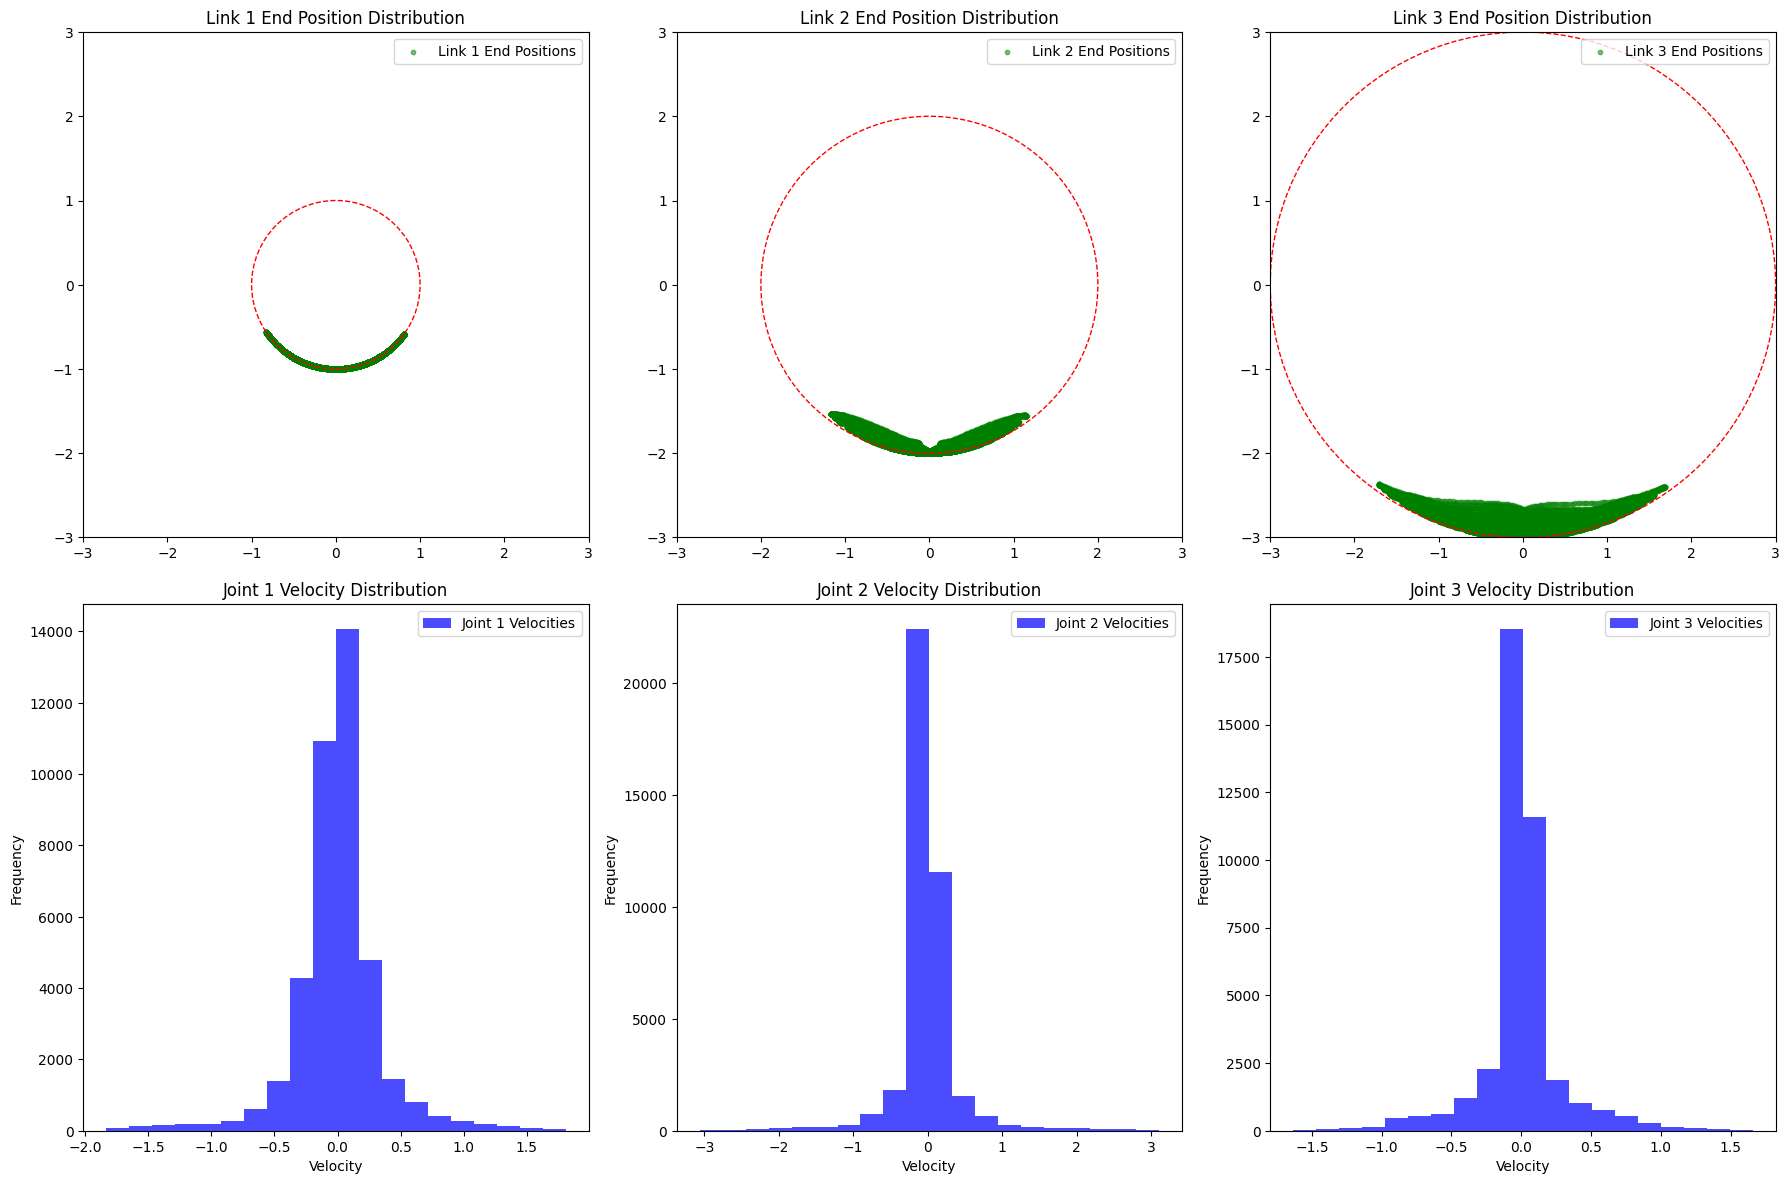

In [ ]:
# Plot the distribution of collected samples
plot_positions_velocities_with_fixed_bounds(data['Y'], [1,1,1])

# Part 2. Learning the forward dynamics.

## Training

After the data is collected, you will then need to complete the cell below to use the collected dataset to learn the forward dynamics.

The code already creates the dataset class and loads the dataset with a random 0.8/0.2 train/test split for you. This cell should save the model that it trains. You should use a specific procedure for saving, outlined below. Note that the saving code is not already included so you will have to add it yourself.

In machine learning, it is a very good practice to save not only the final model but also the checkpoints, such that you have a wider range of models to choose from. We provide a code snippet for you and for each epoch of your training, you should use it to save the model at that epoch.

```
model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
if not os.path.exists(os.path.join(model_dir, model_folder_name)):
    os.makedirs(os.path.join(model_dir, model_folder_name))
torch.save(model.state_dict(), os.path.join(model_dir, model_folder_name, 'dynamics.pth'))
```

The output from running this code should be a folder as below:

```
models/
    2024-03-08_23-57-50/
        epoch_0001_loss_0.00032930/
            dynamics.pth
        epoch_0002_loss_0.00009413/
            dynamics.pth   
        ...  
```

You can see that every time you run this cell, a folder whose name is the time you started will be created under `models`. Checkpoints from all epochs will be saved and then the folder name for saving the checkpoint indicates the epoch number and loss on the holdout test set. Recording checkpoints this way allows you to easily pick the model with the smallest loss.


### Important: choosing the best model

Your code should keep track of the checkpoint with the smallest loss on the test set. You should save the path of that checkpoint to the variable `model_path`. An example value of `model_path` could be `models/2024-03-07_20-14-32/epoch_0046_loss_0.00000005/dynamics.pth`. In the evaluation code, the checkpoint from `model_path` will be loaded and evaluated.

You should also download the `dynamic.pth` file to include in your submission.

A common practice with regards to model saving is to only save models with the best test_loss, rather than checkpoint every epoch. If you want, you can modify the save code to do that instead.

In [ ]:
# %%script false --no-raise-error
# !rm -r /content/models/

In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import os
import numpy as np
import torch.nn as nn
import argparse
import time
import pickle

np.set_printoptions(suppress=True)
torch.manual_seed(42)
class DynamicDataset(Dataset):
    def __init__(self, data_file):
        data = pickle.load(open(data_file, "rb"))
        self.X = data['X'].astype(np.float32)  # X: (N, 9), includes state and action
        # self.Y = data['Y'].astype(np.float32)  # Y: (N, 6), includes next state

        X = data['X']
        Y = data['Y']
        delta_t = 0.01
        initial_velocities = X[:, 3:6]
        final_velocities = Y[:, 3:6]
        delta_v = final_velocities - initial_velocities
        # print('delta_v.shape ', delta_v.shape)
        acceleration = delta_v / delta_t
        print('X.shape ', X.shape)
        print('acceleration.shape ', acceleration.shape)
        self.Y = acceleration.astype(np.float32)  # Y: (N, 3),

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

class Net(nn.Module):
    def __init__(self):
        torch.manual_seed(42)
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 512)  # Input layer: 9 features (ppp vvv ttt)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 92)
        # self.fc3 = nn.Linear(128, 3)
        self.fc4 = nn.Linear(92, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        # x = self.fc3(x)
        x = self.fc4(x)
        return x

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    return test_loss / len(test_loader)

# The ratio of the dataset used for testing
split = 0.2

# Do NOT change
# We are only using CPU, and GPU is not allowed.
device = torch.device("cpu")

dataset = DynamicDataset('data.pkl')
dataset_size = len(dataset)
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

# The name of the directory to save all the checkpoints
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
model_dir = os.path.join('models', timestr)

###################################################################


model = Net().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.000001)#,weight_decay=0.000001
optimizer =torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
criterion = nn.MSELoss()


epochs = 30 #50
best_test_loss = 100
model_path = None  # Initialize model_path as None

# The name of the directory to save all the checkpoints


for epoch in range(1, epochs + 1):
    # Train the model
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()  # Clear the gradients
        output = model(X_batch)  # Forward pass
        loss = criterion(output, Y_batch)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        # scheduler.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)


    # Evaluate the model
    model.eval()
    test_loss = 0
    with torch.no_grad():
        i=0
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, Y_batch)
            test_loss += loss.item() * X_batch.size(0)
    test_loss /= len(test_loader.dataset)

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        # print(test_loss,best_test_loss)
        model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
        if not os.path.exists(os.path.join(model_dir, model_folder_name)):
            os.makedirs(os.path.join(model_dir, model_folder_name))
        torch.save(model.state_dict(), os.path.join(model_dir, model_folder_name, 'dynamics.pth'))
        model_path = os.path.join(model_dir, model_folder_name, 'dynamics.pth')
print('best: ',model_path)
# X.shape  (40400, 9)
# acceleration.shape  (40400, 3)
# Epoch: 1, Train Loss: 2.489563, Test Loss: 0.435874

# Epoch: 13, Train Loss: 0.031051, Test Loss: 0.080623


X.shape  (40400, 9)
acceleration.shape  (40400, 3)
Epoch: 1, Train Loss: 2.489563, Test Loss: 0.435874
Epoch: 2, Train Loss: 0.284555, Test Loss: 0.167708
Epoch: 3, Train Loss: 0.092108, Test Loss: 0.456284
Epoch: 4, Train Loss: 0.077518, Test Loss: 0.035447
Epoch: 5, Train Loss: 0.045836, Test Loss: 0.024805
Epoch: 6, Train Loss: 0.037565, Test Loss: 0.315788
Epoch: 7, Train Loss: 0.056432, Test Loss: 0.083440
Epoch: 8, Train Loss: 0.026748, Test Loss: 0.037756
Epoch: 9, Train Loss: 0.034834, Test Loss: 0.011322
Epoch: 10, Train Loss: 0.021991, Test Loss: 0.035163
Epoch: 11, Train Loss: 0.025491, Test Loss: 0.007379
Epoch: 12, Train Loss: 0.028130, Test Loss: 0.023531
Epoch: 13, Train Loss: 0.031051, Test Loss: 0.080623
Epoch: 14, Train Loss: 0.022536, Test Loss: 0.009486
Epoch: 15, Train Loss: 0.031452, Test Loss: 0.008892
Epoch: 16, Train Loss: 0.012843, Test Loss: 0.015273
Epoch: 17, Train Loss: 0.027161, Test Loss: 0.011769
Epoch: 18, Train Loss: 0.012808, Test Loss: 0.010310
Epoc

In [ ]:
%%script false --no-raise-error
# @title ignore

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch.nn as nn
import argparse
import time
import pickle
import time
np.set_printoptions(suppress=True)
class DynamicDataset(Dataset):
    def __init__(self, data_file):
        data = pickle.load(open(data_file, "rb"))
        self.X = data['X'].astype(np.float32)  # X: (N, 9), includes state and action
        # self.Y = data['Y'].astype(np.float32)  # Y: (N, 6), includes next state

        X = data['X']
        Y = data['Y']
        delta_t = 0.01
        initial_velocities = X[:, 3:6]
        final_velocities = Y[:, 3:6]
        delta_v = final_velocities - initial_velocities
        # print('delta_v.shape ', delta_v.shape)
        acceleration = delta_v / delta_t
        print('acceleration.shape ', acceleration.shape)
        print('X.shape ', X.shape)
        self.Y = acceleration.astype(np.float32)  # Y: (N, 6), includes next state

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

class Net(nn.Module):
    def __init__(self):
        torch.manual_seed(42)
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 512)  # Input layer: 9 features (6 state + 3 action)
        self.fc2 = nn.Linear(512, 128)  # Hidden layer
        self.fc3 = nn.Linear(128, 64)  # Hidden layer
        # self.fc3 = nn.Linear(128, 3)  # Output layer: 6 features (next state)
        self.fc4 = nn.Linear(64, 3)  # Output layer: 6 features (next state)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        # x = self.fc3(x)
        x = self.fc4(x)
        return x

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
    return test_loss / len(test_loader)


# The ratio of the dataset used for testing
split = 0.2

# Do NOT change
# We are only using CPU, and GPU is not allowed.
device = torch.device("cpu")

dataset = DynamicDataset('data.pkl')
dataset_size = len(dataset)
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True)

# The name of the directory to save all the checkpoints
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
model_dir = os.path.join('models', timestr)

# Keep track of the checkpoint with the smallest test loss and save in model_path
model_path = None

epochs = 100
best_test_loss = float('inf')

model = Net().to(device)
for epoch in range(1, epochs + 1):
    # Train the model
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()  # Clear the gradients
        output = model(X_batch)  # Forward pass
        loss = criterion(output, Y_batch)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        # scheduler.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)


    # Evaluate the model
    model.eval()
    test_loss = 0
    with torch.no_grad():
        i=0
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, Y_batch)
            test_loss += loss.item() * X_batch.size(0)
    test_loss /= len(test_loader.dataset)

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

    # Checkpointing
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
        os.makedirs(os.path.join(model_dir, model_folder_name), exist_ok=True)
        model_path = os.path.join(model_dir, model_folder_name, 'dynamics.pth')
        # print(model_path)
        torch.save(model.state_dict(), model_path)


## Prediction

After you are done with training, you need to complete the cell below to load the saved checkpoint (in function init_model) and then use it to predict the new state given the current state and action (in function dynamics_step). Please do not modify the arguments to those functions, even though you might not use all of them.

In [ ]:
from arm_dynamics_base import ArmDynamicsBase
print(model_path)
class ArmDynamicsStudent(ArmDynamicsBase):
    def init_model(self, model_path, num_links, time_step, device):
        self.model = Net()  # Initialize your neural network model
        self.model.load_state_dict(torch.load(model_path, map_location=device))  # Load the trained model weights
        self.model.to(device)
        self.model.eval()
        self.device = device
        self.model_loaded = True

    def dynamics_step(self, state, action, dt):
        # print(self.model_loaded)
        if not self.model_loaded:
            return state  # Return the current state if the model isn't loaded

        action = action.flatten()
        state = state.flatten()
        # print('action, ',action)
        # print('state, ',state)
        # Concatenate state and action
        state_action = np.concatenate((state, action), axis=0).flatten()  # Concatenate along the first dimension
        # print(state_action)
        # Convert to tensor and move to the correct device
        state_action_tensor = torch.from_numpy(state_action).float().to(self.device)
        # print(state_action_tensor)
        with torch.no_grad():  # No need to compute gradients for inference
            predicted_acceleration = self.model(state_action_tensor)
            # print(predicted_acceleration)
        # The predicted_acceleration tensor needs to be reshaped if it doesn't directly match the expected shape.
        acceleration = predicted_acceleration.cpu().numpy().flatten()  # Convert to numpy array and reshape if necessary
        # print(acceleration.shape)
        # Update velocities and positions using the predicted accelerations and the equations
        # [position1, position2, position3, velocity1, velocity2, velocity3]
        new_velocities = state[3:6] + acceleration * dt  # v = v_o + a * dt
        new_positions = state[0:3] + state[3:6] * dt + 0.5 * acceleration * dt**2  # x = x_o + v_o * dt + 0.5 * a * dt^2

        # Combine the new positions and velocities to form the new state
        new_state = np.concatenate((new_positions, new_velocities)).reshape(-1, 1)

        return new_state

models/2024-03-26_01-08-59/epoch_0022_loss_0.00470478/dynamics.pth


In [ ]:
# @title Ignore
%%script false --no-raise-error
from arm_dynamics_base import ArmDynamicsBase

class ArmDynamicsStudent(ArmDynamicsBase):
    def init_model(self, model_path, num_links, time_step, device):
        # ---
        # Your code hoes here
        # Initialize the model loading the saved model from provided model_path
        self.model = None
        # ---
        self.model_loaded = True

    def dynamics_step(self, state, action, dt):
        if self.model_loaded:
            # ---
            # Your code goes here
            # Use the loaded model to predict new state given the current state and action
            # Output should be an array of shape (6,1)
            new_state = None
            return new_state
            # ---
        else:
            return state

# Evaluation and Grading

The total number of points for this project is 15. There are 3 types of tests, each is worth 5 points.

**For each type, there are 50 tests.** For each test, you get a score of 1, 0.5, or 0. Your final grade for each type is the averaged score across 50 tests * 5.

- *Type 1*: for each test, a constant torque randomly sampled from [-1.5Nm, 1.5Nm] is applied to the first joint of the arm for 5 seconds. If the MSE (Mean Squred Error) between the predicted arm state (arm_student) and the ground truth arm state (arm_teacher) is < 0.0005, you get score 1 for this test. If 0.0005 <= MSE < 0.008, you get score 0.5 for this test. Otherwise you get 0.
- *Type 2*: for each test, a torque that linearly increases from 0 to a random torque in [0.5Nm, 1.5Nm] is applied to the first joint of the arm for 5 seconds. If MSE < 0.0005, you get score 1 for this test. If 0.0005 <= MSE < 0.008, you get score 0.5 for this test. Otherwise you get 0.
- *Type 3*: for each test, one torque is applied for the first 2.5 seconds and another torque is applied for the remaining 2.5 seconds. Both torques are sampled from [-1Nm, 1Nm]. If MSE < 0.015, you get score 1 for this test. If 0.015 <= MSE < 0.05, you get score 0.5 for this test. Otherwise you get 0.


In [ ]:
# DO NOT CHANGE
# Set up grading

# Make sure model_path is correctly set
print(model_path)

import importlib
import score
importlib.reload(score)

# Create the teacher arm
dynamics_teacher = ArmDynamicsTeacher(
    num_links=3,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)
arm_teacher = Robot(dynamics_teacher)

# Create the student arm
dynamics_student = ArmDynamicsStudent(
    num_links=3,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)
if model_path is not None:
  dynamics_student.init_model(model_path, num_links=3, time_step=0.01, device=torch.device('cpu'))
arm_student = Robot(dynamics_student)

models/2024-03-26_01-08-59/epoch_0022_loss_0.00470478/dynamics.pth


In [ ]:
# DO NOT CHANGE

# Test on randomly sampled torques from [-1.5, 1.5]
score.score_random_torque(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque = 0.8139619298002381 Nm)

average mse: 1.4119855632179898e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 2 (Torque = -1.4377441519217955 Nm)

average mse: 0.00010423396968596937
Score: 1/1
----------------------------------------


----------------------------------------
TEST 3 (Torque = 0.4009447047788264 Nm)

average mse: 1.149429358925918e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 4 (Torque = 0.7464116476158358 Nm)

average mse: 2.0176317814554274e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 5 (Torque = -0.004478963092228838 Nm)

average mse: 2.3696076588043616e-07
Score: 1/1
----------------------------------------


----------------------------------------
TEST 6 (Torque = -0.825610063407457 Nm)

average mse: 2.1982442821616107e-05
Score: 1/1
-------

In [ ]:
# DO NOT CHANGE

# Test on torques that linearly increase from 0 to a random number from [0.5, 1.5]
score.score_linear_torques(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque 0 -> 1.2713206432667459 Nm)

average mse: 8.648285669852907e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 2 (Torque 0 -> 0.5207519493594015 Nm)

average mse: 1.0476773664415956e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 3 (Torque 0 -> 1.1336482349262753 Nm)

average mse: 6.605384043889041e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 4 (Torque 0 -> 1.2488038825386119 Nm)

average mse: 8.377793401399141e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 5 (Torque 0 -> 0.9985070123025904 Nm)

average mse: 4.432570822607019e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 6 (Torque 0 -> 0.7247966455308477 Nm)

average mse: 1.7600509057228544e-05
Score: 

In [ ]:
# DO NOT CHANGE

# Test on one torque applied to the first 2.5s and another torque applied to the second 2.5s
# Both torques are sampled from [-1, 1]
score.score_two_torques(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque 1 = 0.542641286533492 Nm,  Torque 2 = -0.21494151210682544 Nm)

average mse: 0.0021082100032300878
Score: 1/1
----------------------------------------


----------------------------------------
TEST 2 (Torque 1 = -0.958496101281197 Nm,  Torque 2 = -0.8130792508826994 Nm)

average mse: 0.0002987680800761148
Score: 1/1
----------------------------------------


----------------------------------------
TEST 3 (Torque 1 = 0.26729646985255084 Nm,  Torque 2 = 0.6422113156738569 Nm)

average mse: 0.00014817384647942963
Score: 1/1
----------------------------------------


----------------------------------------
TEST 4 (Torque 1 = 0.4976077650772237 Nm,  Torque 2 = -0.6976959607148723 Nm)

average mse: 0.00374988463534804
Score: 1/1
----------------------------------------


----------------------------------------
TEST 5 (Torque 1 = -0.0029859753948191514 Nm,  Torque 2 = -0.23177110261560085 Nm)

average mse: 7.392561511294387e-06
Scor

# Other Requirements and Hints

- Training time: This project requires more training than the previous projects. But less than a hundred epochs of training (<= 25 mins) should suffice for achieving the full points. Again, the shorter your model training time is the better.
- Dataset: Choosing the right policy to collect datasets for this project is important. You need to think about how to do it properly so that your trained model will pass the tests successfully. It is in general very hard to learn the ground truth forward dynamics completely (that works for any distribution of actions), and during testing small errors can accumulate, leading to drastic failure in the end. You might want to try overfitting on the test cases, to begin with. Make sure that your dataset is less than 100 Mb, which is pretty much sufficient for achieving full marks. Collecting datasets can be time-consuming and you could parallelize this process for some speed-up using [ray](https://www.ray.io/). Make sure your data collection takes <= 25 mins.
- NO GPU: No GPU is required or allowed for this assignment and we will test your code without GPUs.
- Loss Function: This is essentially a regression problem so think about what losses are suitable for regression.
- Optimizer: While it is possible to use a simple optimizer to achieve the desired accuracy, the training time can be quite high. There exists a number of optimizers implemented in PyTorch that have much faster convergence.
- Seeding. Please use seeding in your code to make sure your results are reproducible.